In [1]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model, svm
import statsmodels.api as sm
import numpy as np
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import NearMiss

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("SDSS-DR14.csv")
df

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


## Data Description
- Position Data
    - objid: Object ID
    - ra: Right Ascension
    - dec: Declination

- Wavelength magnitude {u,g,r,i,z}
    - u: Ultraviolet
    - g: Green
    - r: Red
    - i: Infrared - 7600 Â
    - z: Infrared - 9100 Â

- Optical obs {redshift,plate,mjd,fiberid}
    - redshift: Wavelenght displacement
    - plate: SDSS plug plate used
    - mjd: Modified Julian Date
    - fiberid: Fiber number

Following data will not be used because they do not describe object characteristics

- objid
- ra
- dec
- run
- rerun
- camcol
- field
- specobjid
- plate
- mjd
- fiberid

In [4]:
#Drop unused columns
df.drop(columns = ['objid','ra','dec','run','rerun','camcol','field','specobjid','plate','mjd','fiberid'], inplace=True)

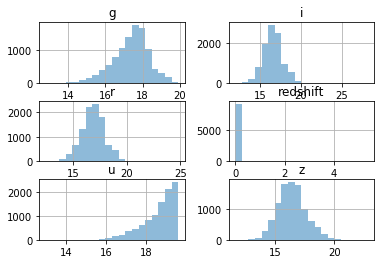

In [5]:
ax = df.hist(bins = 20, alpha = 0.5)


In [6]:
Y = df['class']

In [7]:
X = df.drop(columns = ['class'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .3, random_state=25)

In [9]:
print('Total train samples by class \n', y_train.value_counts())
print('Ratios: \n', y_train.value_counts()/y_train.value_counts().min())

Total train samples by class 
 GALAXY    3545
STAR      2852
QSO        603
Name: class, dtype: int64
Ratios: 
 GALAXY    5.878939
STAR      4.729685
QSO       1.000000
Name: class, dtype: float64


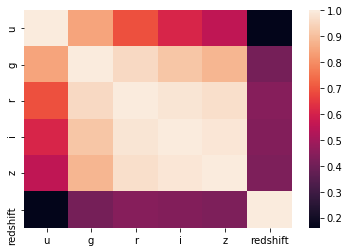

In [10]:
sb.heatmap(X_train.corr())
plt.show()

### Es necesario balancear el dataset de entrenamiento
Ante la posibilidad de que el modelo sea sobreentrenado se usara <i>Undersampling</i> como balanceador

In [11]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
undersampled_trainX, undersampled_trainY = undersample.fit_resample(X_train, y_train)
undersampled_train = pd.concat([pd.DataFrame(undersampled_trainY), pd.DataFrame(undersampled_trainX)], axis=1)

In [12]:
undersampled_train.groupby('class').count()

,u,g,r,i,z,redshift
class,,,,,,
GALAXY,603,603,603,603,603,603
QSO,603,603,603,603,603,603
STAR,603,603,603,603,603,603


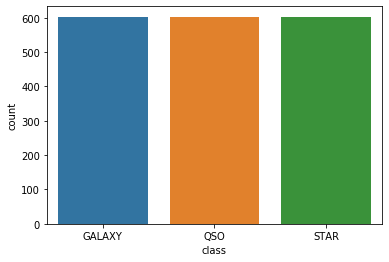

In [13]:
sb.countplot(x = 'class', data = undersampled_train)
plt.show()

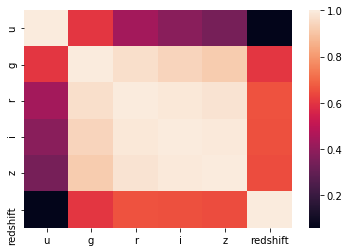

In [14]:
sb.heatmap(undersampled_trainX.corr())
plt.show()

# Logistic Regression

In [15]:
#Aprendizaje
LogReg = LogisticRegression(max_iter = 10000)
#profiling
time_logreg = %timeit -r10 -n1 -o LogReg.fit(undersampled_trainX, undersampled_trainY)

278 ms ± 16.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [16]:
#Predicciones
y_pred = LogReg.predict(X_test)

In [17]:
#Evaluación del rendimiento del clasificador
logreg_matrix = confusion_matrix(y_test, y_pred)
logreg_matrix

array([[1178,    4,  271],
       [  13,  233,    1],
       [  43,    5, 1252]])

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      GALAXY       0.95      0.81      0.88      1453
         QSO       0.96      0.94      0.95       247
        STAR       0.82      0.96      0.89      1300

    accuracy                           0.89      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.90      0.89      0.89      3000



# Decision tree

In [28]:
%%time
from sklearn import tree
#Entrenamiento
clf = tree.DecisionTreeClassifier()
clf.fit(undersampled_trainX,undersampled_trainY)
time_tree = %timeit -r10 -n1 -o clf.fit(undersampled_trainX,undersampled_trainY)

10.5 ms ± 1.34 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
CPU times: user 117 ms, sys: 3.23 ms, total: 121 ms
Wall time: 119 ms


In [29]:
#Predicciones
y_pred = clf.predict(X_test)
#Evaluación del rendimiento del clasificador
from sklearn.metrics import confusion_matrix
tree_matrix = confusion_matrix(y_test, y_pred)
print(tree_matrix)
#Print de la matriz de confusión
print(classification_report(y_test, y_pred))

[[1320  119   14]
 [  11  236    0]
 [   0    3 1297]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.91      0.95      1453
         QSO       0.66      0.96      0.78       247
        STAR       0.99      1.00      0.99      1300

    accuracy                           0.95      3000
   macro avg       0.88      0.95      0.91      3000
weighted avg       0.96      0.95      0.95      3000



# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rng_fst = RandomForestClassifier(n_estimators=15)
#Profiling
time_forest = %timeit -r10 -n1 -o rng_fst.fit(undersampled_trainX,undersampled_trainY) 

48.5 ms ± 6.34 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [22]:
#Predicciones
y_pred = rng_fst.predict(X_test)
#Evaluación del rendimiento del clasificador
from sklearn.metrics import confusion_matrix
forest_matrix = confusion_matrix(y_test, y_pred)
print(forest_matrix)
#Print de la matriz de confusión
print(classification_report(y_test, y_pred))

[[ 989  449   15]
 [   7  240    0]
 [   0    0 1300]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.68      0.81      1453
         QSO       0.35      0.97      0.51       247
        STAR       0.99      1.00      0.99      1300

    accuracy                           0.84      3000
   macro avg       0.78      0.88      0.77      3000
weighted avg       0.94      0.84      0.86      3000



In [23]:
print(logreg_matrix)
print(tree_matrix)
print(forest_matrix)

[[1178    4  271]
 [  13  233    1]
 [  43    5 1252]]
[[1338  101   14]
 [  12  235    0]
 [   0   14 1286]]
[[ 989  449   15]
 [   7  240    0]
 [   0    0 1300]]
